# SEP tutorial (with `astropy.io.fits`)
This notebook follows the steps from the SEP tutorial (https://sep.readthedocs.io/en/stable/tutorial.html) but **uses `astropy.io.fits`** to read the example FITS image instead of `fitsio`.

**What this notebook does**
- download the example FITS image used by the SEP tutorial (from the SEP GitHub repository)
- display the image
- estimate and subtract a spatially-varying background using `sep.Background`
- detect sources with `sep.extract`
- overplot object ellipses on the image
- perform simple circular aperture photometry with `sep.sum_circle`

> **Requirements:** `sep`, `astropy`, `numpy`, `matplotlib`. Install with `pip install sep astropy matplotlib`.

> If the SEP example FITS URL has moved, change the `IMAGE_URL` variable in the first code cell to point where the example image is hosted (the SEP GitHub `data` folder contains it).

In [1]:
# Cell 1: imports and where to download the example FITS image
# Replace IMAGE_URL if SEP moves the example image in their repository.
IMAGE_URL = "https://raw.githubusercontent.com/sep-developers/sep/main/data/image.fits"

import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.utils.data import download_file
from astropy.io import fits

# Make plots look reasonable in notebooks
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
# Cell 2: download the FITS file and read the image data with astropy
# This uses astropy.utils.data.download_file which caches the file locally.
# If your environment has no internet, put the example 'image.fits' in the notebook folder and set filename to it.
try:
    print("Downloading example FITS from:", IMAGE_URL)
    fname = download_file(IMAGE_URL, cache=True)
    print("Saved to:", fname)
except Exception as e:
    print("Download failed (offline?), trying to use local 'image.fits' if present. Error:", e)
    fname = "image.fits"

# Read image data (primary HDU)
data = fits.getdata(fname)
# Astropy returns big-endian arrays for FITS by default; SEP prefers native byte order.
# Ensure native byte order (see SEP docs for details).
if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and not np.little_endian):
    data = data.byteswap().newbyteorder()

print("data shape:", data.shape, "dtype:", data.dtype)

Saved to: C:\Users\conra\.astropy\cache\download\url\8ae8007c01ea24845a290e6259a91514\contents
data shape: (256, 256) dtype: float32


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


Text(0.5, 1.0, 'Raw image (display)')

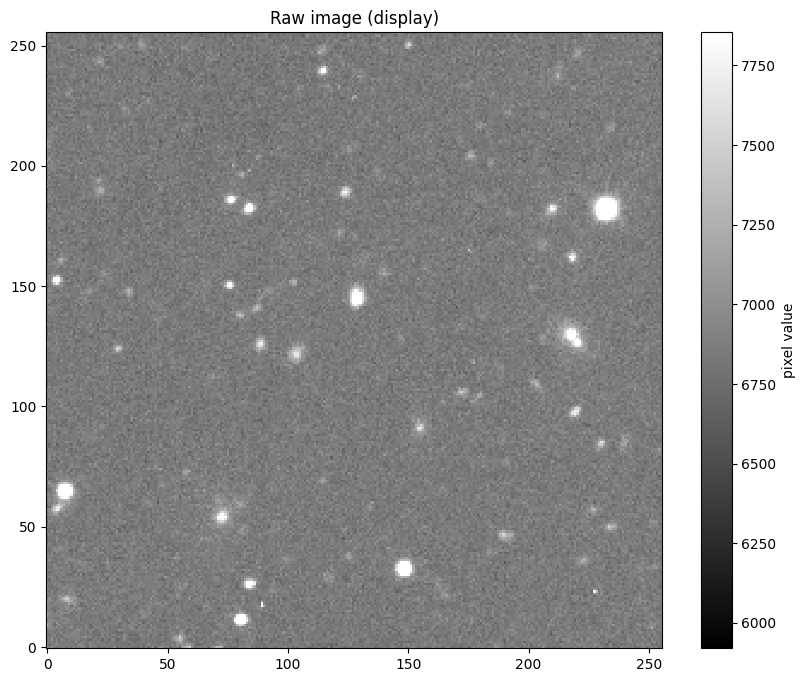

In [3]:
# Cell 3: display the raw image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar(label='pixel value')
plt.title('Raw image (display)')

plt.savefig("raw_image.png", dpi=200, bbox_inches="tight")

global background (mean): 6852.04931640625
global RMS: 65.46174621582031


(np.float64(-0.5), np.float64(255.5), np.float64(-0.5), np.float64(255.5))

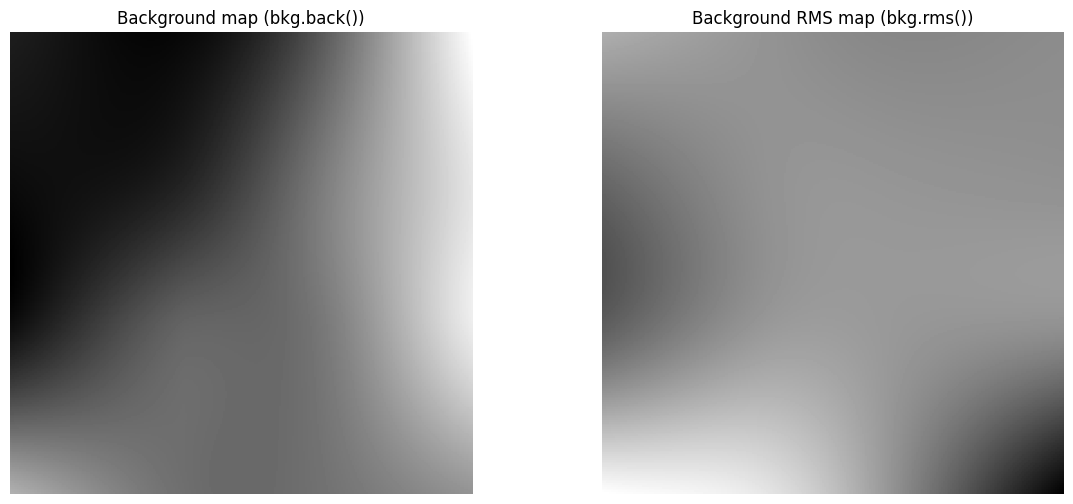

In [4]:
# Cell 4: estimate and display the spatially varying background and RMS with SEP
# The Background object internally computes a background map (bkg.back()) and an RMS map (bkg.rms()).
bkg = sep.Background(data)    # default box size is usually fine for the small example image
print("global background (mean):", bkg.globalback)
print("global RMS:", bkg.globalrms)

bkg_image = bkg.back()
bkg_rms = bkg.rms()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(bkg_image, interpolation='nearest', origin='lower', cmap='gray')
axes[0].set_title('Background map (bkg.back())')
axes[0].axis('off')
axes[1].imshow(bkg_rms, interpolation='nearest', origin='lower', cmap='gray')
axes[1].set_title('Background RMS map (bkg.rms())')
axes[1].axis('off')

fig.savefig("background_and_rms.png", dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Background-subtracted image')

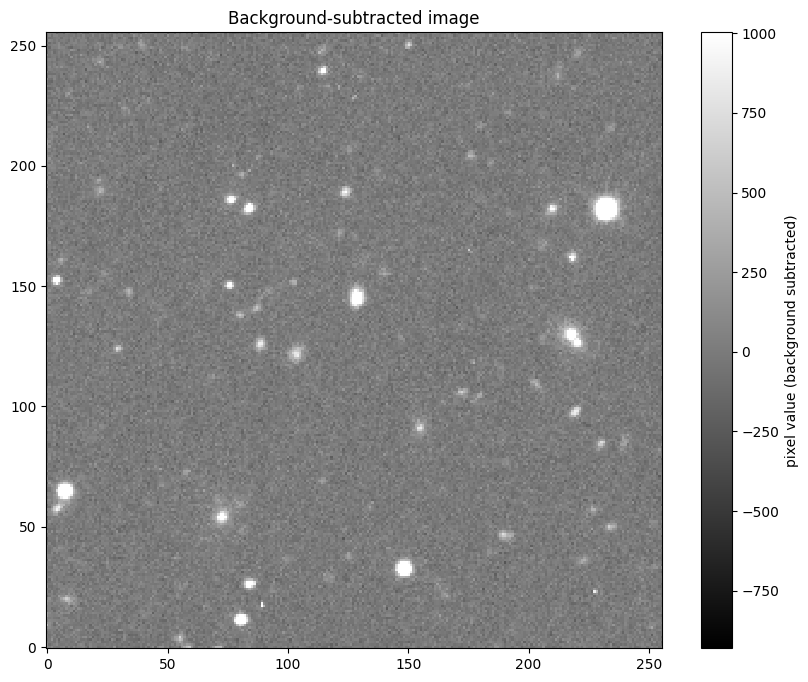

In [5]:
# Cell 5: subtract the background (to create a background-subtracted image)
# You can do this by: data_sub = data - bkg.back()  OR use the Background object directly in some SEP calls.
data_sub = data - bkg
m, s = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar(label='pixel value (background subtracted)')
plt.title('Background-subtracted image')

plt.savefig("background_subtracted.png", dpi=200, bbox_inches="tight")

In [6]:
# Cell 6: detect objects using sep.extract
# We use a threshold of 1.5 * global RMS (same as the SEP tutorial).
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
print("Number of objects detected:", len(objects))
print("Fields available in objects.dtype.names:", objects.dtype.names)

Number of objects detected: 69
Fields available in objects.dtype.names: ('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')


Text(0.5, 1.0, 'Detected objects (ellipses)')

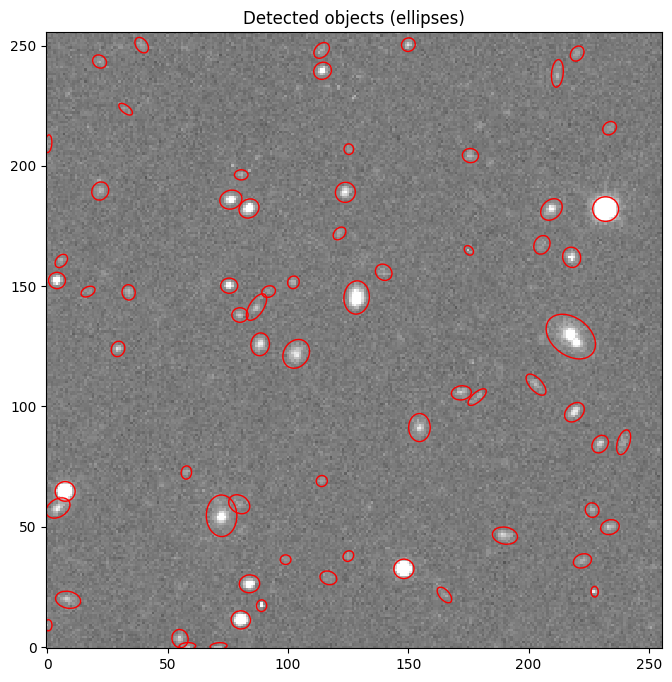

In [7]:
# Cell 7: over-plot elliptical approximations for the detected objects
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
ax.set_title('Detected objects (ellipses)')

fig.savefig("object_detection.png", dpi=200, bbox_inches="tight")

In [8]:
# Cell 8: perform circular aperture photometry at the detected object centroids
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
# show first 10 fluxes
for i in range(min(10, len(flux))):
    print(f"object {i}: flux = {flux[i]:.6f} +/- {fluxerr[i]:.6f}  flag={flag[i]}")

object 0: flux = 2249.159297 +/- 291.027802  flag=16
object 1: flux = 3092.220430 +/- 291.592204  flag=16
object 2: flux = 5949.868379 +/- 356.562003  flag=0
object 3: flux = 1851.426582 +/- 295.028816  flag=16
object 4: flux = 72736.386914 +/- 440.172206  flag=0
object 5: flux = 3860.756152 +/- 352.163162  flag=0
object 6: flux = 6418.913789 +/- 357.458973  flag=0
object 7: flux = 2210.707656 +/- 350.791223  flag=0
object 8: flux = 2741.607227 +/- 352.277746  flag=0
object 9: flux = 20916.875566 +/- 376.966138  flag=0
